## Import necessary packages:

In [3]:
%matplotlib inline
from datetime import datetime
import pandas as pd
import glob
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.style as style

from lstchain.io.io import dl1_params_lstcam_key, dl2_params_lstcam_key
from lstchain.reco.utils import get_effective_time, radec_to_camera
from lstchain.reco.utils import compute_theta2, extract_source_position, clip_alt
from ctapipe.containers import EventType
from ctapipe.coordinates import CameraFrame
from astropy.coordinates import AltAz, SkyCoord, EarthLocation
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy.time import Time
from gammapy.stats import WStatCountsStatistic

style.use('tableau-colorblind10')
plt.rcParams['font.size'] = 20

## This function gets the source position in camera coordinates for any source

Alternatively you can use lstchain.reco.extract_source_position() just giving the source name (p.e. "Crab")

In [2]:
def extract_source_position_from_coord(
    data, coord, equivalent_focal_length=28 * u.m
):
    """
    Extract source position from data
    Parameters:
    -----------
    pandas.DataFrame data: input data
    str observed_source_name: Name of the observed source
    astropy.units.m equivalent_focal_length: Equivalent focal length of a telescope
    Returns:
    --------
    2D array of coordinates of the source in form [(x),(y)] in astropy.units.m
    """

    obstime = pd.to_datetime(data["dragon_time"], unit="s")
    pointing_alt = u.Quantity(data["alt_tel"], u.rad, copy=False)
    pointing_az = u.Quantity(data["az_tel"], u.rad, copy=False)
    source_pos_camera = radec_to_camera(
        coord,
        obstime,
        pointing_alt,
        pointing_az,
        focal=equivalent_focal_length,
    )
    source_position = [source_pos_camera.x, source_pos_camera.y]
    return source_position

## Choose your input files

In [2]:
#%%time
#data=pd.DataFrame()
#runs=['09443'] # You can concatenate several runs
#for run in runs:
#    input_file='/home/kenta.terauchi/Work/lst-analysis//source/GRB220930A/2022_09_30/DL2/dl2_LST-1.Run'+run+'.h5'
#    data=pd.concat([data, pd.read_hdf(input_file, key=dl2_params_lstcam_key)])

CPU times: user 12.6 s, sys: 9.83 s, total: 22.5 s
Wall time: 26.6 s


In [12]:
%%time
data=pd.DataFrame()
#filelist = sorted(glob.glob('/fefs/aswg/workspace/seiya.nozaki/data/GRB221009A/20221105_nsb_tune/DL1_crab/20221105/data/dl1_*Run10345.*.h5'))
filelist = sorted(glob.glob('/fefs/aswg/data/real/DL1/20*/v*/tailcut84/dl1_*Run09686.*.h5'))
[print(file) for file in filelist]

for input_file in filelist:
    data=pd.concat([data, pd.read_hdf(input_file, key=dl1_params_lstcam_key)])

/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10339.h5
/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10340.h5
/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10341.h5
/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10342.h5
/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10343.h5
/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10344.h5
/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10345.h5
/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10346.h5
/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10347.h5
/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10348.h5
/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10349.h5
/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10350.h5
/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10351.h5
/fefs/aswg/data/real/DL1/20221105/v0.9/tailcut84/dl1_LST-1.Run10352.h5
/fefs/

## Take a look at the dataframe

In [5]:
data

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,...,mc_type,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,ucts_trigger_type,trigger_time,event_type
0,9602,1,19171.743889,4.282662,0.012723,-0.028724,0.031415,-1.153821,1.188668,0.004213,...,-9999,0.923079,1,50.0,50.0,16.0,1,1,1.665436e+09,32
1,9602,2,113.575157,2.055283,-0.120406,0.008027,0.120674,3.075026,0.066784,0.002729,...,-9999,0.378830,1,50.0,50.0,16.0,1,1,1.665436e+09,32
2,9602,3,126472.873116,5.101997,0.004735,-0.001892,0.005099,-0.380160,1.170054,0.001639,...,-9999,0.972663,1,50.0,50.0,16.0,5,5,1.665436e+09,0
3,9602,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,50.0,50.0,16.0,1,1,1.665436e+09,32
4,9602,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,50.0,50.0,16.0,1,1,1.665436e+09,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983,9602,2334984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,50.0,50.0,16.0,32,32,1.665438e+09,2
2984,9602,2334985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,50.0,50.0,16.0,1,1,1.665438e+09,32
2985,9602,2334986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,50.0,50.0,16.0,1,1,1.665438e+09,32
2986,9602,2334987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,50.0,50.0,16.0,1,1,1.665438e+09,32


In [6]:
data.keys()

Index(['obs_id', 'event_id', 'intensity', 'log_intensity', 'x', 'y', 'r',
       'phi', 'length', 'length_uncertainty', 'width', 'width_uncertainty',
       'psi', 'skewness', 'kurtosis', 'time_gradient', 'intercept',
       'leakage_intensity_width_1', 'leakage_intensity_width_2',
       'leakage_pixels_width_1', 'leakage_pixels_width_2', 'n_pixels',
       'concentration_cog', 'concentration_core', 'concentration_pixel',
       'n_islands', 'alt_tel', 'az_tel', 'sin_az_tel', 'calibration_id',
       'dragon_time', 'ucts_time', 'tib_time', 'ucts_jump', 'mc_type', 'wl',
       'tel_id', 'tel_pos_x', 'tel_pos_y', 'tel_pos_z', 'trigger_type',
       'ucts_trigger_type', 'trigger_time', 'event_type', 'delta_t'],
      dtype='object')

Keys are the same as DL1 plus the reconstructed quantities

## Get the observation time and store some useful variables

In [13]:
obstime_real = get_effective_time(data)[0]
gammaness = np.array(data.gammaness)
leakage_intensity_width_2 = np.array(data.leakage_intensity_width_2)
intensity = np.array(data.intensity)
alt = np.array(data.alt_tel)
zd = 90.0 - np.rad2deg(alt)
az = np.array(data.az_tel)
wl = np.array(data.wl)
event_type = np.array(data.event_type)
event_id = np.array(data.event_id)
obs_id = np.array(data.obs_id)
dragon_time = np.array(data.dragon_time)
obstime_real.to(u.min)

Start obs time : 2022-11-05 23:36:42.390
Observation delay : 39499.7 min
Zenith (deg): 56.1 -> 27.9


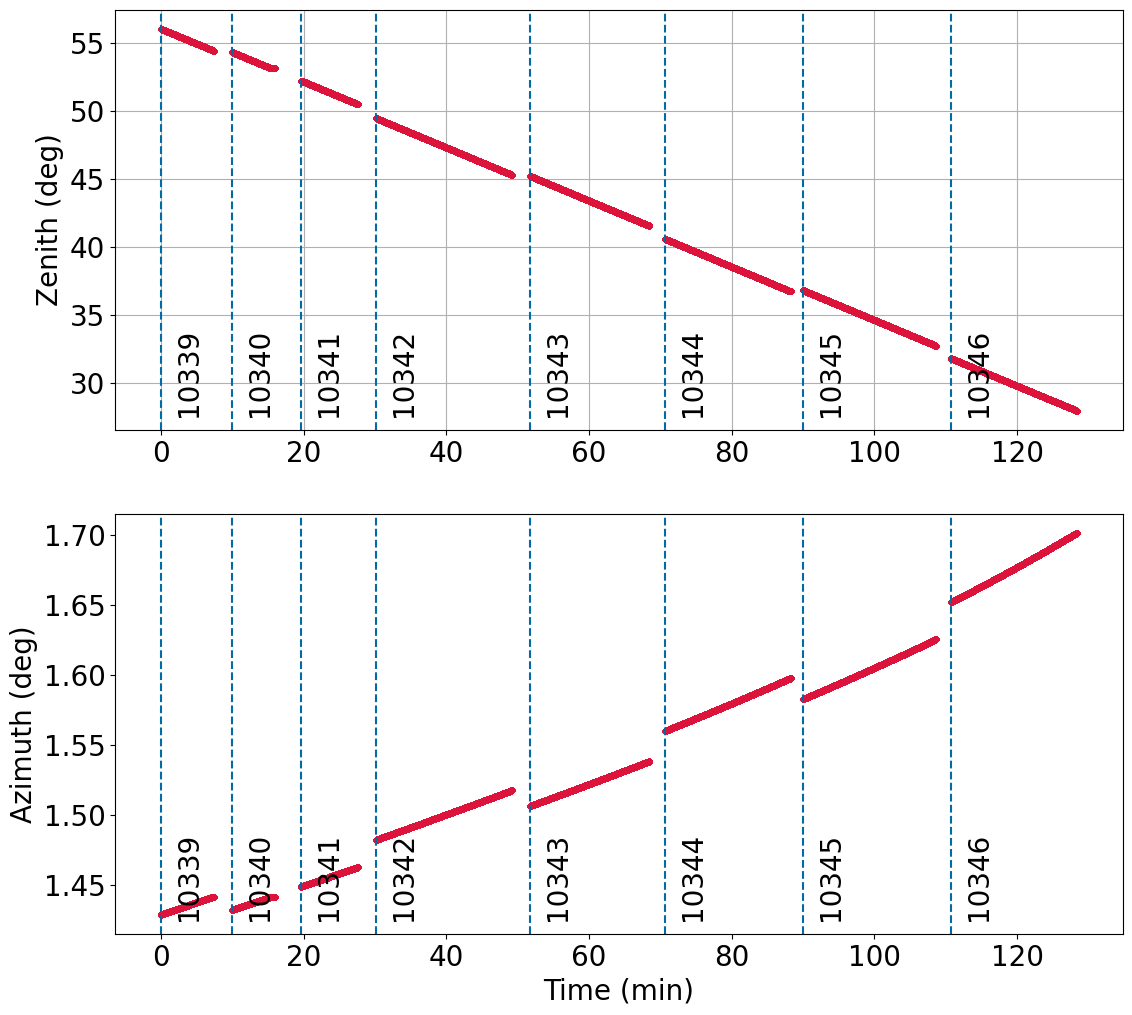

In [14]:
T0 = Time("2022-10-09 13:16:59", format='iso', scale='utc')
#obs_start = datetime.utcfromtimestamp(np.min(data.dragon_time))
tstart = Time(np.min(dragon_time), format='unix', scale='utc')
delay = tstart - T0

print(f'Start obs time : {tstart.utc.iso}')
print(f'Observation delay : {delay.to_value(u.min):.1f} min')
print(f'Zenith (deg): {zd[0]:.1f} -> {zd[-1]:.1f}')

run_start_idx = [0]
for idx in range(len(obs_id)-1): 
    if obs_id[idx] != obs_id[idx+1]:
        run_start_idx.append(idx+1)

time = (dragon_time - np.min(dragon_time))/60.

plt.figure(figsize=(13,12))

ax_zd = plt.subplot(211)
ax_az = plt.subplot(212, sharex=ax_zd)

ax_zd.plot(time, zd, color='crimson', ls='None', marker='.')
for i in run_start_idx:
    ax_zd.axvline(time[i], ls="--")
    ax_zd.text(time[i]+2, np.min(zd), str(obs_id[i]), rotation="vertical", fontsize="medium")
ax_zd.set_ylabel('Zenith (deg)')
#ax_zd.set_ylim(0, 20)
ax_zd.grid()

ax_az.plot(time, az, color='crimson', ls='None', marker='.')
for i in run_start_idx:
    ax_az.axvline(time[i], ls="--")
    ax_az.text(time[i]+2, np.min(az), str(obs_id[i]), rotation="vertical", fontsize="medium")
plt.xlabel('Time (min)')
ax_az.set_ylabel('Azimuth (deg)')
#ax_az.grid()

plt.show()

## Define some cuts 

In [29]:
gammaness_cut=0.6
intensity_cut=100.
intensity_cut_high=1.0e15
leakage_cut=0.2
alt_min=0 * np.pi / 180
wl_cut=0.0
THETA2_GLOBAL_CUT=0.04
theta2_range=(0,1)
norm_range_theta2_min=0.2
norm_range_theta2_max=0.4

In [30]:
condition = (gammaness > gammaness_cut) \
            & (intensity > intensity_cut) \
            & (intensity < intensity_cut_high) \
            & (alt > alt_min) \
            & (wl > wl_cut) \
            & (event_type == 32)\
            & (leakage_intensity_width_2 < leakage_cut)

In [31]:
selected_data=data[condition] #We apply now the cuts so the calculations will be quicker

## Define the source coordinates

#### <font color='red'>Set the correct coordinates!</font> 

In [42]:
coordinates = SkyCoord(83.6333333, 22.0123611, frame=ICRS, unit='deg') # Crab

## Calculate the source true position 

In [43]:
%%time
true_source_position = extract_source_position_from_coord(selected_data, coordinates)
#true_source_position = extract_source_position(selected_data, 'Crab') #If its a catalogued source, like the Crab, you can use this lstchain function
off_source_position = [element * -1 for element in true_source_position]

CPU times: user 5min 14s, sys: 1.22 s, total: 5min 15s
Wall time: 5min 18s


## Compute theta2 of the ON and OFF data

In [13]:
theta2_on = np.array(compute_theta2(selected_data, true_source_position))
theta2_off = np.array(compute_theta2(selected_data, off_source_position))

## Create histograms for theta2 plots

In [14]:
#nbins=100 #Choose your preferred number of bins
nbins=round((theta2_range[1]/THETA2_GLOBAL_CUT)*2) # Make the histogram so there are only two bins before the theta2 cut
hist_on, bin_edges_on=np.histogram(theta2_on,density=False, bins=nbins, range=theta2_range)
hist_off, bin_edges_off=np.histogram(theta2_off, density=False, bins=nbins, range=theta2_range)

bin_width=bin_edges_on[1]-bin_edges_off[0]
bin_center=bin_edges_on[:-1]+(bin_width/2)

## Calculate the Li&Ma significance

In [15]:
N_on = np.sum(hist_on[bin_edges_on[1:]<=THETA2_GLOBAL_CUT])
N_off = np.sum(hist_off[bin_edges_off[1:]<=THETA2_GLOBAL_CUT])

idx_min = (np.abs(bin_edges_on - norm_range_theta2_min)).argmin()
idx_max = (np.abs(bin_edges_on - norm_range_theta2_max)).argmin()

Non_norm = np.sum(hist_on[idx_min:idx_max])
Noff_norm = np.sum(hist_off[idx_min:idx_max])

alpha = Noff_norm / Non_norm

stat = WStatCountsStatistic(n_on=N_on, n_off=N_off, alpha=alpha)
significance_lima = stat.sqrt_ts

textstr = r'N$_{{\rm on}}$ = {:.0f} '\
            f'\n'\
            r'N$_{{\rm off}}$ = {:.0f} '\
            f'\n'\
            r'Time = {:.1f}'\
            f'\n'\
            r'LiMa Significance = {:.1f} $\sigma$ '.format(N_on,
                                                      N_off,
                                                      obstime_real.to(u.h),
                                                      significance_lima)

props = dict(boxstyle='round', facecolor='lightpink', alpha=0.85)

## Plot Theta2

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.errorbar(bin_center, hist_on, xerr=bin_width/2.0, yerr=np.sqrt(hist_on), 
            fmt='o', label='ON data', ms=10, color='crimson', lw=2.5)
ax.errorbar(bin_center, hist_off, xerr=bin_width/2.0, yerr=np.sqrt(hist_off),
            label='Background', ms=10, color='darkcyan', drawstyle='steps-mid')
ax.set_xlim(0, 0.5)
#ax.set_ylim(6750, 7850)
ax.grid(ls='dashed')
ax.axvline(THETA2_GLOBAL_CUT, color='black',ls='--',alpha=0.75)
ax.set_xlabel("$\\theta^{2} [deg^{2}]$")
ax.set_ylabel("Counts")
#ax.legend(bbox_to_anchor=(0.99, 0.8))
ax.legend(loc='lower right')
ax.set_title("GRB220311A: Run 7414-7423 \n (intensity > 50; gammaness > 0.7)")
 
txt = ax.text(0.60, 0.97, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

plt.show()

## Plot excess counts

In [87]:
excess=hist_on-hist_off
excess_err=np.sqrt(np.sqrt(excess**2))

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.errorbar(bin_center, excess, yerr=excess_err,fmt='o',color='forestgreen',label='Excess counts')
ax.bar(bin_edges_on[:-1], excess, width = bin_width, align='edge', color='limegreen',alpha=0.5)
ax.axhline(0, color='darkgray')
ax.set_xlim(0,0.5)
ax.grid()
ax.axvline(THETA2_GLOBAL_CUT, color='black', ls='--', alpha=0.75)
ax.grid(ls='dashed')
ax.set_xlabel("$\\theta^{2} [deg^{2}]$")
ax.set_ylabel("Counts")
ax.legend(title=f'Significance = {significance_lima:.1f} $\sigma$')

# We can make theta2 plots for different bins in energy

## Define the energy binning

In [18]:
log_reco_energy = np.array(selected_data.log_reco_energy)
emin=0.01 * u.TeV
emax=10 * u.TeV
n_bins_energy=3
log_energy = np.linspace(np.log10(emin.to_value()),
                         np.log10(emax.to_value()),
                         n_bins_energy + 1)

## Now calculate the significante and produce a theta2 plot for each energy bin

In [ ]:
for i in range(n_bins_energy):
    condition_energy_bin= (log_reco_energy < log_energy[i+1]) \
        & (log_reco_energy >= log_energy[i])
    data_bin=selected_data[condition_energy_bin]
    theta2_on = np.array(compute_theta2(data_bin, (true_source_position[0][condition_energy_bin], true_source_position[1][condition_energy_bin])))
    theta2_off = np.array(compute_theta2(data_bin, (off_source_position[0][condition_energy_bin], off_source_position[1][condition_energy_bin])))
    
    hist_on, bin_edges_on=np.histogram(theta2_on,density=False, bins=nbins, range=theta2_range)
    hist_off, bin_edges_off=np.histogram(theta2_off, density=False, bins=nbins, range=theta2_range)

    bin_width=bin_edges_on[1]-bin_edges_off[0]
    bin_center=bin_edges_on[:-1]+(bin_width/2)
    N_on = np.sum(hist_on[bin_edges_on[1:]<=THETA2_GLOBAL_CUT])
    N_off = np.sum(hist_off[bin_edges_off[1:]<=THETA2_GLOBAL_CUT])

    idx_min = (np.abs(bin_edges_on - norm_range_theta2_min)).argmin()
    idx_max = (np.abs(bin_edges_on - norm_range_theta2_max)).argmin()

    Non_norm = np.sum(hist_on[idx_min:idx_max])
    Noff_norm = np.sum(hist_off[idx_min:idx_max])

    alpha = Noff_norm / Non_norm

    stat = WStatCountsStatistic(n_on=N_on, n_off=N_off, alpha=alpha)
    significance_lima = stat.sqrt_ts

    textstr = r'N$_{{\rm on}}$ = {:.0f} '\
            f'\n'\
            r'N$_{{\rm off}}$ = {:.0f} '\
            f'\n'\
            r'Time = {:.1f}'\
            f'\n'\
            r'LiMa Significance = {:.1f} $\sigma$ '.format(N_on,
                                                      N_off,
                                                      obstime_real.to(u.h),
                                                      significance_lima)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)
    
    fig, ax = plt.subplots(figsize=(12, 10))

    ax.errorbar(bin_center, hist_on, yerr=np.sqrt(hist_on), fmt='o', label='ON data', ms=10, color='crimson')
    ax.errorbar(bin_center, hist_off, yerr=np.sqrt(hist_off),fmt='s',label='Background', ms=10, color='cornflowerblue')
    ax.set_xlim(0, 0.5)
    ax.grid(ls='dashed')
    ax.axvline(THETA2_GLOBAL_CUT, color='black',ls='--',alpha=0.75)
    ax.set_xlabel("$\\theta^{2} [deg^{2}]$")
    ax.set_ylabel("Counts")
    ax.legend(bbox_to_anchor=(0.99, 0.8))
    ax.set_title(r'{:.2f} TeV to {:.2f} TeV'.format(10**log_energy[i], 10**log_energy[i+1]))


    txt = ax.text(0.57, 0.98, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

## Plot the position of the selected events

### In camera coordinates

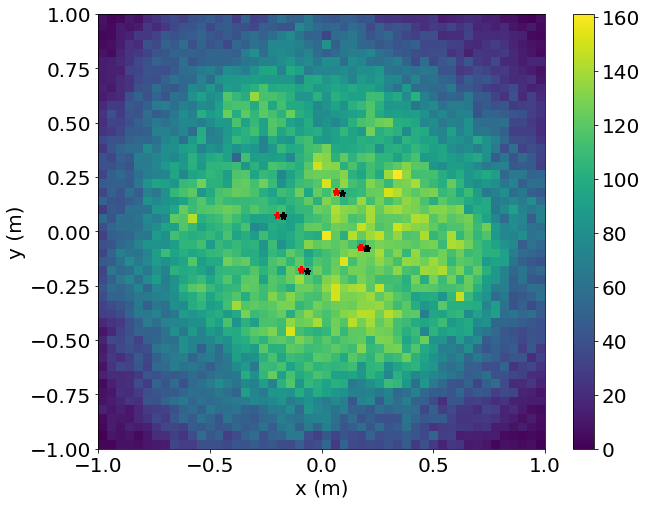

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))

skymap=ax.hist2d(selected_data['reco_src_x'], 
           selected_data['reco_src_y'], bins=50, 
           range=[(-1,1), (-1,1)])
#ax.scatter(true_source_position[0], true_source_position[1], c='red', marker='*')
#ax.scatter(off_source_position[0], off_source_position[1], c='black', marker='*')

fig.colorbar(skymap[3], ax=ax)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
plt.show()

You can see the wobble positions if you use one more than one run

### In Sky coordinates

In [17]:
location = EarthLocation.from_geodetic(-17.89139 * u.deg, 28.76139 * u.deg, 2184 * u.m) #Location of LST1
obstime = pd.to_datetime(selected_data["dragon_time"], unit="s")
horizon_frame = AltAz(location=location, obstime=obstime)

In [18]:
%%time
pointing_alt = u.Quantity(selected_data["alt_tel"], u.rad, copy=False)
pointing_az = u.Quantity(selected_data["az_tel"], u.rad, copy=False)
pointing_direction=SkyCoord(alt=clip_alt(pointing_alt), az=pointing_az, frame=horizon_frame)
camera_frame = CameraFrame(focal_length=28 * u.m,
                           telescope_pointing=pointing_direction,
                           obstime=obstime,
                           location=location)  

CPU times: user 1min 28s, sys: 1.61 s, total: 1min 29s
Wall time: 1min 29s


In [19]:
camera_coords = SkyCoord(x=selected_data['reco_src_x'], y=selected_data['reco_src_y'], frame=camera_frame, unit=(u.m, u.m))

In [20]:
radec_coords=camera_coords.transform_to(frame=ICRS)

Text(0.5, 1.0, '(intensity > 50; gammaness > 0.7)')

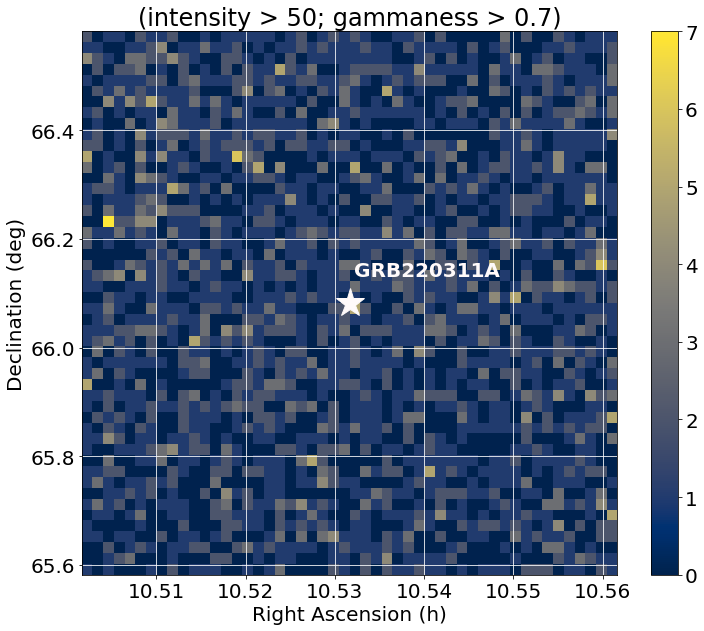

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))

h = radec_skymap=plt.hist2d(radec_coords.ra.to_value(u.hourangle), radec_coords.dec.value, 
                            range=[(coordinates.ra.to_value(u.hourangle)-0.03, coordinates.ra.to_value(u.hourangle)+0.03),
                                   (coordinates.dec.value-0.5, coordinates.dec.value+0.5)],
                            bins=50, cmap='cividis'
                            )
ax.plot(coordinates.ra.to_value(u.hourangle), coordinates.dec.value, marker='*', 
        color='snow', markersize=30)
ax.text(coordinates.ra.to_value(u.hourangle)+5.0e-4, coordinates.dec.value+0.05, 'GRB220311A', color='snow', fontsize=20, fontweight='bold')
fig.colorbar(h[3], ax=ax)
ax.grid(color='white')
ax.set_xlabel("Right Ascension (h)")
ax.set_ylabel("Declination (deg)")
ax.set_title('(intensity > 50; gammaness > 0.7)')